In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import required libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

print(tf.__version__)


2.6.4


## helper functions

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

## Create the series using helper functions

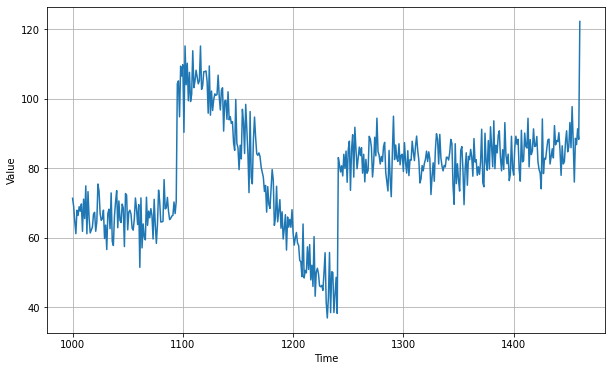

In [4]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

## Create the dataset

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2022-08-10 20:46:43.473449: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Build the model

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)

## Train the model 

In [7]:
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

2022-08-10 20:46:44.072672: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Visualize metrics

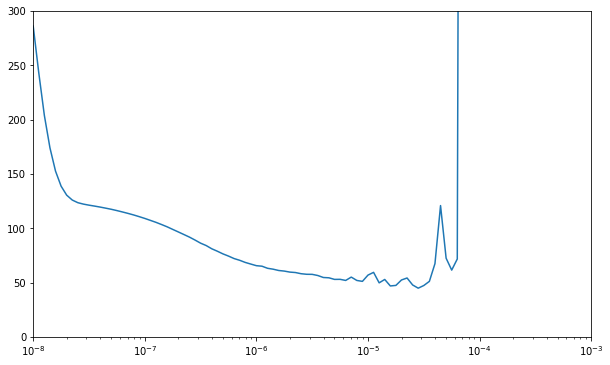

In [8]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10, 6))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

## Retrain the model 

Epoch 1/300
31/31 [==============================] - 1s 3ms/step - loss: 754.2519
Epoch 2/300
31/31 [==============================] - 0s 3ms/step - loss: 128.4949
Epoch 3/300
31/31 [==============================] - 0s 2ms/step - loss: 71.7140
Epoch 4/300
31/31 [==============================] - 0s 2ms/step - loss: 65.3960
Epoch 5/300
31/31 [==============================] - 0s 2ms/step - loss: 61.6145
Epoch 6/300
31/31 [==============================] - 0s 2ms/step - loss: 60.0253
Epoch 7/300
31/31 [==============================] - 0s 2ms/step - loss: 56.8339
Epoch 8/300
31/31 [==============================] - 0s 2ms/step - loss: 55.7345
Epoch 9/300
31/31 [==============================] - 0s 2ms/step - loss: 53.8077
Epoch 10/300
31/31 [==============================] - 0s 2ms/step - loss: 53.0397
Epoch 11/300
31/31 [==============================] - 0s 2ms/step - loss: 56.8450
Epoch 12/300
31/31 [==============================] - 0s 2ms/step - loss: 51.3540
Epoch 13/300
31/31 [===

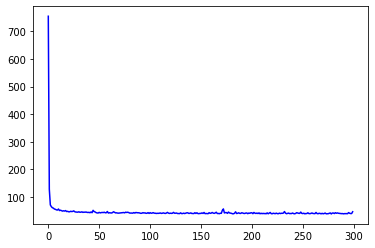

In [9]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=300)

loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

## Forcasting using the trained model

[56.84503173828125, 51.35396957397461, 52.5779914855957, 50.77235412597656, 49.31416320800781, 50.47700119018555, 49.43614196777344, 51.20030975341797, 47.74293899536133, 48.5284423828125, 46.9161262512207, 46.86598587036133, 48.67292785644531, 47.702823638916016, 48.23714065551758, 50.12364959716797, 47.05421447753906, 46.00163650512695, 45.85396194458008, 45.44820785522461, 46.77404022216797, 45.25375747680664, 45.36149597167969, 46.67461395263672, 44.71590042114258, 45.64324188232422, 45.23920440673828, 46.01346969604492, 44.85255432128906, 44.33916473388672, 44.87950134277344, 43.40617752075195, 46.24131774902344, 43.534000396728516, 52.16572189331055, 47.65354919433594, 46.23303985595703, 43.782752990722656, 42.70216369628906, 42.443603515625, 44.72157669067383, 42.85871505737305, 43.9177360534668, 44.38698959350586, 44.00055694580078, 45.218360900878906, 43.29050064086914, 43.40544128417969, 47.83280563354492, 42.30961227416992, 43.370506286621094, 42.86842346191406, 42.440872192

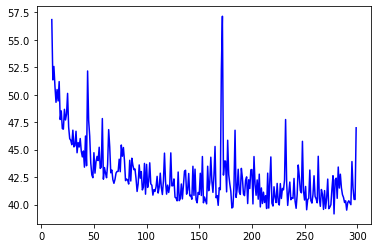

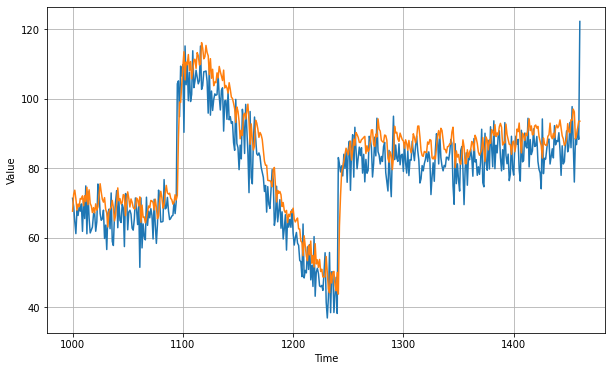

MAE: 6.380097389221191


In [10]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

print(f"MAE: {tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()}")